<hr style="height:2px" > 


# CNN 과적합 최소화 


## 데이터 증식

합성곱 신경망의 경우 학습 샘플이 충분하지 안은 경우 매우 높은 확률로 과적합이 발생한다.  물론 지나치게 샘플이 적은 경우는 이를 통한 실용적인 학습 자체가 거의 불가능하겠지만 어느정도 크기의 샘플이라면 이러한 학습 이미지에 변형을 가해 학습 샘플을 다양화시킴으로서 과적합의 발생을 최소화할 수 있다. 

keras 는 ImageDataGenerator 에서 이러한 기능을 자체적으로 제공하는데 지난 시간에 사용했던 

<pre>
    trdg = ImageDataGenerator( rescale = 1./255 ) 
</pre>

를 확장해 여러 변형옵션을 가할 수 있다. 

In [2]:
from keras.preprocessing.image import ImageDataGenerator

trdg = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    width_shift_range = 0.1,    
    height_shift_range = 0.1,    
    shear_range = 0.1,
    zoom_range = 0.1,
    horizontal_flip = True,
    fill_mode = 'nearest'
)


Using TensorFlow backend.


이를 통해 가해지는 변형 예제를 다음 코드를 이용해 확인이 가능하다. 

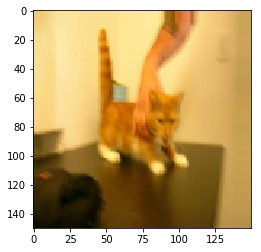

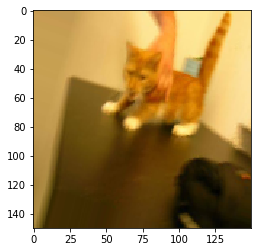

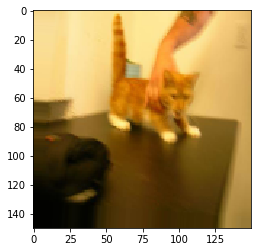

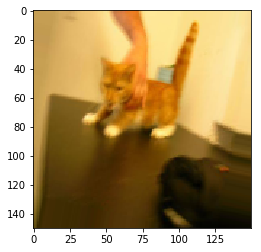

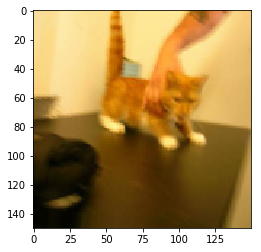

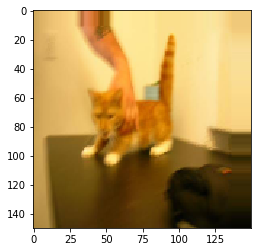

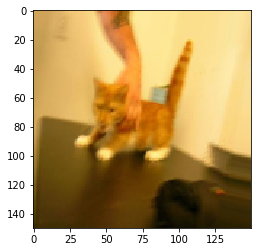

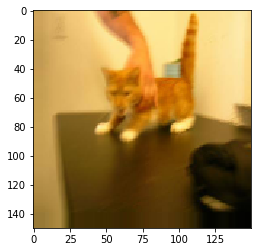

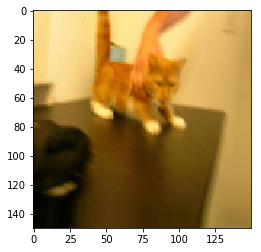

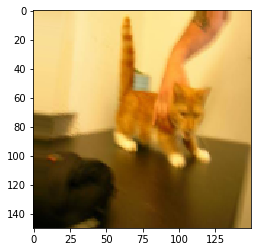

In [32]:
from keras.preprocessing import image
import matplotlib.pyplot as plt 
import os 

img = image.load_img("dnc/train_s/cat/cat.0.jpg", target_size = (150,150))
x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)

i = 0 

for batch in trdg.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0])) 
    i += 1
    if i % 10 == 0:
        break
        
plt.show()        


이제 이를 이용해 새로이 학습을 진행해보도록 하겠다. trdg = ImageDataGenerator 부분은 위의 예를 적용시켜주고 테스트 이미지는 따로 변형이 필요없기 때문에 이전 코드를 그대로 적용시킨다. 

In [4]:
from keras.preprocessing.image import ImageDataGenerator

trdg = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    width_shift_range = 0.1,    
    height_shift_range = 0.1,    
    shear_range = 0.1,
    zoom_range = 0.1,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

ttdg = ImageDataGenerator(rescale = 1./255 )

train_gen = trdg.flow_from_directory( 
    "dnc/train_s",
    target_size = (150,150),
    batch_size = 20,
    class_mode = 'binary') 

val_gen = ttdg.flow_from_directory(
    "dnc/test",
    target_size = (150,150),
    batch_size = 20,
    class_mode = 'binary') 

Found 2500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


## 드롭 아웃 

데이터 증식과는 조금 다른 방법으로 과적합을 줄이는 방법이 있다. 일정확률로 노드를 생략해서 학습을 시키는 것인데 이는 결과적으로 학습 데이터의 전파의 흐름을 일부러 누락시킴으로서 데이터 증식의 효과와 함께 학습된 결과가 지나치게 특화되는 것을 막는 효과를 갖게된다. 

<img src = "https://miro.medium.com/proxy/1*iWQzxhVlvadk6VAJjsgXgg.png">



드롭아웃은 드롭아웃을 적용할 레이어 뒤에 배치하여 특정 레이어의 노드를 걸러낼 수 있으며 주로 MaxPooling layer 뒤에 배치한다. 

<pre>
    ...
    model.add(layers.Conv2D(128,(3,3), activation = 'relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.5))
    ...
</pre>






이제 모델을 만들고 학습을 시작하도록 하겠다. 

In [5]:
from keras import layers 
from keras import models
import keras

keras.backend.clear_session()
model = models.Sequential() 
model.add(layers.Conv2D(32,(3,3), activation = 'relu', input_shape=(150,150,3)))
model.add(layers.MaxPooling2D((2,2))) 

model.add(layers.Conv2D(64,(3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(128,(3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.5))

model.add(layers.Conv2D(128,(3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.5))


model.add(layers.Flatten())
model.add(layers.Dense(512,activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

model.compile(optimizer = 'rmsprop',
                loss = 'binary_crossentropy',
                metrics = ['acc'] )

In [7]:
history = model.fit_generator(train_gen, steps_per_epoch = 50,  epochs = 50, validation_data = val_gen, validation_steps = 50).history


Epoch 1/50
50/50 [==============================] - 12s 235ms/step - loss: 0.5474 - acc: 0.7100 - val_loss: 0.5361 - val_acc: 0.7530
Epoch 2/50
50/50 [==============================] - 13s 256ms/step - loss: 0.5523 - acc: 0.7330 - val_loss: 0.5323 - val_acc: 0.7340
Epoch 3/50
50/50 [==============================] - 12s 232ms/step - loss: 0.5305 - acc: 0.7580 - val_loss: 0.4988 - val_acc: 0.7640
Epoch 4/50
50/50 [==============================] - 10s 201ms/step - loss: 0.5391 - acc: 0.7320 - val_loss: 0.5516 - val_acc: 0.7250
Epoch 5/50
50/50 [==============================] - 12s 245ms/step - loss: 0.6028 - acc: 0.7220 - val_loss: 0.5248 - val_acc: 0.7420
Epoch 6/50
50/50 [==============================] - 12s 233ms/step - loss: 0.5375 - acc: 0.7270 - val_loss: 0.5231 - val_acc: 0.7440
Epoch 7/50
50/50 [==============================] - 11s 212ms/step - loss: 0.5406 - acc: 0.7240 - val_loss: 0.5345 - val_acc: 0.7440
Epoch 8/50
50/50 [==============================] - 12s 246ms/step - 

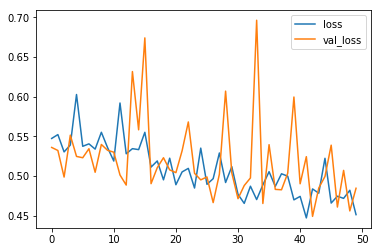

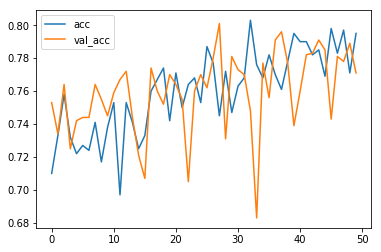

In [10]:
import matplotlib.pyplot as plt
plt.plot(history['loss'], label = 'loss')            
plt.plot(history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()

plt.plot(history['acc'], label = 'acc')            
plt.plot(history['val_acc'], label = 'val_acc')
plt.legend()
plt.show()

아마 전시간의 학습에 비해 학습 정확도는 천천히 올라가지만 과적합의 발생이 상당히 줄어든 것을 쉽게 느낄 수 있을 것이다. 이는 학습 이미지의 변형을 통해 지나치게 특정이미지에 관여한 특징이 학습에서 제거됨으로서 좀더 일반적인 학습이 가능해지기 때문이다. 




## 학습한 모델 저장 및 로드하기

매번 우리가 분류기를 사용하기 위해서 이를 다시 학습시켜야 한다면 매우 끔직한 일이다. 또한 학습이 매우 잘 진행되고 있던 분류기가 과적합으로 흘러서 성능이 떨어질 수도 있다. 이런 문제를 해결하기 위해서는 학습 중간이나 학습 종료후 학습된 웨이트값들을 저장해 둠으로서 이를 재사용하거나 재학습 할 수 있다. 케라스는 아주 간편하게 모델과 학습된 가중치를 저장하고 읽어들이는 방법을 제공한다. 

저장 

<pre>     
    model.save("mymodel.h5")
</pre>

읽어들이기 
<pre>
    from keras.models import load_model
    model = load_model("mymodel.h5")    
</pre>
    
그럼 위에서 예제를 학습한 모델을 직접 다음 코드를 통해서 저장해보도록 하겠다. 



In [8]:
model.save("cnn_dnc.h5")

jupyter 의 디렉토리 리스트를 새로고침 해보면  모델이 저장된 것을 볼 수 있을 것이다. 

### <font color = 'red'> 연습문제 6-1 : 모델 로딩해서 테스트해보기 

새로 페이지를 만든 후에 저장된 모델을 읽어서 인터넷의 고양이,개 사진에 대해 테스트를 해보자

<hr style="height:2px" > 

# 미리 트레이닝된 모델 사용

사실 개인이 성능좋은 분류기를 학습시키는 것은 매우 어려우며, 많은 시간과 많은 경험을 필요로 한다. 무엇보다 대부분 경우 충분한 학습 샘플을 얻기 어렵기 때문에 많은 경우 기존에 다른 사람이 학습된 모델을 사용해야 하는 경우가 있을 것이다. 특히 딥러닝의 붐을 일으키는데 기준이 된 ImageNet 데이터셋에 대한 학습은 수많은 종류의 모델들이 장시간 학습되고 최적화되어 제공된다.  유명한 모델들은 케라스 자체에서도 지원되는데 
<b> <a href = "https://keras.io/applications/" style = "font-weight:10"> 링크 </a> </b> 를 보면 지원되는 다양한 이미지 인식 모델들을 볼 수 있다. 

이번에는 이러한 모델을 사용하는 사례로서 Resnet50 을 로딩해 사용하는 체험해보도록 하겠다. 


## Resnet50 모델 로드

모델 로딩은 상상 이상으로 간단하다. 

In [4]:
import keras 
from keras.applications import resnet
model = resnet.ResNet50()


102973440/102967424 [==============================] - 17s 0us/step


### VGG로 이미지 예측 

이제 인터넷에서 아무 이미지나 골라서 이를 VGG를 통해 예측해보도록 하겠다. 

[[1.86075722e-05 1.20571485e-06 7.93246841e-07 1.22721588e-06
  3.91648209e-05 2.89783202e-06 4.46094560e-07 2.87596913e-06
  8.52879293e-06 8.97426986e-08 6.57535324e-08 6.04904784e-08
  9.58631716e-08 2.52452494e-08 2.32429244e-07 1.35336180e-07
  1.22829022e-07 1.43993680e-06 4.23998785e-07 1.49050852e-08
  1.23127961e-07 2.72872694e-05 8.91596699e-07 7.30947158e-06
  2.98602072e-06 2.75435951e-07 9.82456854e-08 3.74979976e-07
  2.12407073e-07 2.19028422e-07 5.42160770e-08 8.69131185e-08
  2.03059855e-07 1.02834902e-05 7.06546052e-06 8.44578437e-07
  1.26615923e-05 5.83182782e-06 3.27691197e-07 1.60516197e-06
  7.48687938e-08 1.80025233e-06 2.22997826e-07 2.92079790e-07
  1.55823585e-07 2.42780629e-07 4.55124280e-07 1.56401839e-07
  3.31458273e-06 1.30834877e-07 3.39309992e-07 2.56483958e-07
  5.15242562e-07 1.02001827e-07 1.89545347e-07 4.05203025e-07
  7.14618338e-08 1.34629460e-07 1.25640412e-07 6.16678733e-07
  1.01832619e-07 9.34052082e-07 3.30158656e-07 3.84977341e-07
  5.7201

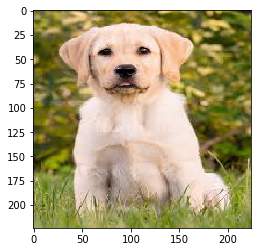

In [18]:
from urllib.request import urlopen
from keras.preprocessing import image
import matplotlib.pyplot as plt 
import numpy as np

url = 'data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxMTEhUTExMVFhUWGBgYFxgYGBgXGBUYGhcYFxoXHRcYHSggGBolGxgWITEhJSkrLi4uFx8zODMtNygtLisBCgoKDg0OGxAQGy0mICYtLS0yLS0tKy0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLf/AABEIAQMAwgMBIgACEQEDEQH/xAAcAAACAgMBAQAAAAAAAAAAAAAEBQMGAAIHAQj/xABDEAABAwIEAwUGBAQDBgcAAAABAAIRAwQFEiExQVFhBiJxgZETMqGxwfAHFELRI1Ji4XKC8TNTkqKywhUWJDRDc6P/xAAZAQADAQEBAAAAAAAAAAAAAAABAgMEAAX/xAAtEQACAgICAQQBAgUFAAAAAAAAAQIRAyESMVEEEyJBYTJxFEKBwfAVM1Jysf/aAAwDAQACEQMRAD8ACr4e7KXwp7F7QyHLR1/ULzTLdJ+CnxG3a1sgQV4cppy4P9yyf2gq3sqT2mAsr2lMNAy7JRY35YFcMHNOowPckgpWyipnuB/l3DI5kHwW2MdmKZGekcp3029ERVxK3pydEMzHPa91jTqqKUl0UqPTFN9eVDTDIkjRVW8qVGuJLDE7xor1dn2EOc3NKUY1iLajYa3hv/ZBuLSsRx/IjpXmcieCx144GNY4Ly1EmMspr+Wloaxhc7gACT8Fmkql8ToptbNbaXNly1uajYg6FeU6VxTd36NQDeMp22U9zRztlzC076iEZqndMp2hfVpuDZYM0BJqlxVD2vcDDTMJxYXjqVSCJaefBMMTyjvFkg7qqyqtEnG/sIp/iA1tMBrTMJM/tRUqOJOngo7u2p1G/wANu3RLXWLh4KL4SA5z+2NrLtM9jjxBTezvhVDtYPxVds7BsZihrmuWHuyFTC4yfCIG3HbJMRYc5bmJPzTfs1i7KVFzKpgid+STYa01Kg4klW227JMqu/iBW9RFKlJHY+V2hDh/bAsY9pk6nL57JWMfqx3pIVsrfhy3PLHkDkg8ZwQW47w05qUVjfR2RZEhPbmhWbEQfDil172cIMs1BRjcjDLSmtpdEhP7mTE7j14IRkIR2RqLFaRiD1iX/UJ+ClhlN+Y5w3ZDU6jrglpbEIC0xd7Tl06py3F20R3RJK6GFrodST7PBgWVpKSVcTdTOQHSU2qdqS4e7EpFc02vdmVMeJJ7On18Q8OD2ZtzGye9jK0k+0ERoEDgtk3KCTCttrgTDBdI+qeO04R3/b+pWEaqUiarYG6MAhrB+reTyhAf+QCahmsMh/p737K12zA0Q2GgfBSMuJmNv24rUsGNJWrYrtgWF9lragO6yTxLjmnrGwTWnRa0aAN8BCjDiSvKtRV0ukcosKLdFHUoteCHgEHgROiibVJhbP1R5A4iq47L2jv/AIgOoJBUd/2ZoupZKYDTGhMn1ndNnSQo6NXh8FN48b04oKT+jm9eyqWoc11F0To4DunrKT3dXNGmi7FUcCIOo4qsX3ZCjUzGm5zHHUcWz4cB4LJP0q/kG3RQxaGJGyixegxzBlGqe3FpVt3eyrNEEHK4HuujkgsPy1KxpjWFj3jlbVE3G9Fdwyo6k4PDSQ3orNhfawVKwae6Dx6ovE8OLNCO6eOyWXPZqg1mdru8Nd1b3I5Vs7jKHQ+7R4vUtmio10jkg6+MNvKBa5uscVSa1++pUDKj5YDp1Vgs8Qp09o0U/Y47D7t/sUq9sX0yRqNdEfgt04d1yZ45iTKxENhRWlJkEka8Fb3VXGRHjvQSaxWJQ66dPFYl9t+DuR5QuRO+qKqvKRUWHNKcU3yFRuUXcRYu0SHWAm2C4PUruytERuTsBzSawou9o3iSQAOfRdWoMFuxrAdSRmPMnT05I405St9F4Qsnw7CqNu0aZ3j9bhx6DZqNtrjNLp6JXfVTBUtge61vGJ9Vp5eDSoJIY165yho3d5QPH1TK0oZW9UjtjnuAAe6OHXx8PmjO0PaOhaN/iva0bAcXHkGjVx6CSVWPWycu9Dak4Tvrx6Lys7dUDAO2FO5rFlPO39QD2lsjaRIEg6H1Vx9tPolba00cop7TJqL4EdVLXuQ06oCi0kSkPa/GBbUzVgvcBo2dyl5P6H4q9lzpOBEhL8TYWEVBts76FUbs/wDiO4ZPzdH2IqOyte17HgHTRzQczNwJLYPNdGrtFRhHBwTyWqfZOLp2ugP2uqhdVhyGw+rnZH6mGDx2JBUtwJ15cFllJmpRVhNUMeyKjWubycA4ehVGxfAhZ3LLqlPsXnK9v+7J2/yn4K5z3UL2jps/KVGv4gR0MyCjJ840/BDJBLZVO2OPsNLK3UuEaLmNe7rBuVxcBwlXbCbdvtQ6pqB8FaK+HW1aCWggegWbE1FEJRc92cVc4zJRNG5jiusYvgVo6kYDZjouWVsG75E92dFdSjIjLG4h1pVbUGQCSp7q1qs0I0Knw3D20m5mmTvupDd1KhAfEA8FHJBw2hovX5FUOWK0ihR6fBYu/iJDcWVbFMLdROqFbcQFb+3ddheGCJVVp2clMppLYrhT0MLCpFWk/WGuaT5GV0y/AcMzTLe64eq51YsGUg7q09lsSBaaL+E5eoO4VMMtF8bp/uPrzWOuqlsd3ngBHyCHqVJHUaffkirNsUz98VVGhi7CcZb+ZqN17jsp04kafT1VU/ELsveXVd1djhDdGCYyjQk6CZJ+QTjC2Re3HVzHf8jR9PirvQ7wylXVqRGVOJyHsj2cu6dwKlVzi4AkS5xPCR3tp8vJdltKctUX5VoPz8OSm9rBCWTblsaKSjSNqFAgRKqHbfAX126QehmCDoZg8ldJ4ryo2Qka8DJ+Tj2C/hW7PNRwynhGv7T/AH8V1zDrY0qbKcyGtA16CEXbtESApQNCnl8q2TTS0kVTs5VPta7T+mq9vTUNf8yU1riClOCf+5uf/tJ//NgTu5Ys8lo0J7IqbZEKv9u7zuimD1P0H3zR2IX4pNL3GAPmdgqzUpPuQ5/EqDyapE83gQ0qkbpvg9/SnK4jXZJadPJUIfzW+KUWvgt4QoqT5U0ZU6LBiOFiczScvKdFWL/BQSSHHyKf2WIDJkJnTRV29l73NbtJStyTDJL6AbEauZm2W1G+DSWoYYXUa+ZKJurGAOau0qoi5eCXzWLZjBAnksXfw8P+QfkA0bKq/wDiPMlSUKRGpR1OrDNfRJn3hkjgl4TnJr6HtJWNDeNG3mpad1lcHt3GqVMajbRw2I058lfHiUNWDnZdMIxNlUaESIkcuEqy0md0jmPp+65dZ0yyq19Pn5Qdx1XTalwABPRV6NWOTkqfZWKLmtvKhLtS1kDXXgT8FcqF0AA7hCoON0S2q2vBykubPn+8qz4Yc9IDhwPQ6/NUctaOS3sdVa/dnnquddrO2+TSlcMbvDR75iO8dO6DPjoeUm91wA2D/LC4T217PinVc/No50cIJjbptx4quCK+xM0mlobUu2tZx1uQ3xcR8dl0zsN2n/NtyuPfZ+oRD2nw0kRr4hfOttSaTD8zZ2IbOvKJEz0XcvwwwdluwmTLo0O45z16DlxT5UqJ4pSbOisrZXEcD9UQ2pohGt1B8lLUeGtkrIm1ZpkkI8Eb/FuDx9p9Gj6fFOt1U8KxA+1q6RndI8dgn9C5gDU6qblTplONq0U/tlWBqinwZBjqdZ9ChLDHPZjLGibdo8N9pXzTu0T5afRJ7rDQwjiPVYMudRnxISTts1GCG5mqDEr09mKjaZJOq3w+/dbvDf0LfGe1pPcYJ03R5X0JUatiBtq9sqSyAa7vLShfuJJet69PMM4Ty+fZNKtoy5rkuIGyR3lw6SAUebvOQw6FeflwHajTmnjHyScU+gana1yAeYBWKwsuWgAabLxHQ/D8lfpXIEkjRQ1bZpbnBTu3qUmg03t1+CW3ls0TkWiCqhJLR5hjGEd4pnTxKk3uNZPUbJPRoiROgVstsLY5k0wCQFPKk7obHFg1rWY9waGQSQP7qz4nUA0LhqdOmsSeirbagpuEiCCn9rhz64lx0OuwS4sya+ejTFuGkT4tZsfSayJAGhPrKzs+/KwtP6SI8CmosctMDchKqtNzQ4sAk8DtI1WpMZbRJit3AME6bj+6592gOckAzwid/v4SUbi+PPqDIKTw7UEEcQDx4jThy6JBb2Vaczawa47kQY0n9QOUQB11lVg/IsmL2YQ+mQ40iG8TGg108OH3t07sU8ZQAdfv19foqZSwa6qTTddPIIkg1HcZMEA6jhxTHDMPr2dT+HmcwAF0wIAA2k6AR8yuyTjXYYKnpHXKNTTj5re5dI8tFU7PF6td9NjGFrXaueQIAA4DmZ8laDyCgmUaEdtY5XuOgHFTt1j9QOxnVN6dpII5qq4w6rSqhtMbnUclH1XJRTQqycXYL2q9qKjXDRoaB8Z+qTVLl5EgzCe47icsDHt1dA+yvamBt9mPZmHH4rJGUX+pEJW5NplTvK5fEoOtSmI4bptfYfUp+82OvBQYeO+ARurtca4k+9MCqwGxGqgpXZ93mri/Cqcz0VTvrYCs4t4JuKvkxXa6Nm4U4uDiY5I7GaDmtGXWUPUvHZdSvbS7MFzztt0UnN3tD8UlSE/sX9ViLdiAJJhYuv8AAKXkstPCWOaHTqdSUmx2rTpnK06/MptZ3p9jlA1A3VKvQXVDJ1lasSU29i5HxQ9qWoqUW1G7jVPMDxBlOkc0zxSS0pEMyg6LLWxObU6Ewmap8h8TZ5dVTUqOePdJkdFa8KxlwYBpoEGcKa3RE4XgntHw06cY4KbgnryMvi7H+DYi6q/LE+ElT16MOOisGGWDKLA1ojn181DiNEEdVsWHihlP6OfY5gZec7HFpBnTed59UkubBzMzm7nfr5LoNzT2Eff7JfiFjLdBJkH4ypZF4Kxd9lSotrhzSABPTh4KxYdg/tg4VS454zGSCY+nCEWKTYkDbp99U5sO6G6Rv8f7qKi2yjdI9w/C6dBsMB5CTMeCPoUdJKxrhKmDpMBaIw2Sc2EUWLS8w+nU1c0SNjxHmp6YUi0KKapmeT2c/wC2PZlzmF1MukagHUaeCSYniT6baTgdR7w8tV0rFW90kGNFybGG6uAMmSvO9TgippLVjRtqy1WfaW2rU8tSAY4qm17dxqk0pyg6coQmCWftK/s9iRPlIH1Vru7b8uMpgg7HyWeeOSXeh+1sApe1doSk15c02PLXRKPfelknU9UmoU2VHlzv9FyyfGybW6QDcPL3QzXkE1t8KqNbNSIKJw+ixpLgPBNMMD7g9/Ro4IuVqxI46exGcMZ9lYrecJp81iWy3tlMoXrg3YapYKLnVJ4ko1mgRFo3vShjqDag+ybXLskoTT3K3bdS5Q3lCpUOmwQZluhCrxk41YeTjLosTb9zob8eS6P2ZsQ2k0nciep8ZXIq1wKTQ4arrPY279pa03cx4fBavSW9sM07H73IO6KIlCVpM8luYqAKo4qOnSndTV9N1JZ05AJUntlOkDi15j7lF0qAHmifZqRzYAQ4nchSSc6Y2rUub/tCmtAIxR0mFNatpWgK9KoSFnaFpNF0cNVx9/druO4K7dXpBzS0jQghcUxqoaVd9MjYkcPosvqYWr+x1KjKRb7bM12V3AgrXFMQqOJFR+aNuHySurRLu80wVlqSD39Vh4yUdk3l5aRq6+dsdlth1cSUSaVN2oUbrcA6KUJWidSjLs3ZcESeCYYJiRLy3ZI7isfdG68t3PpEPjxV8eO1Y8MrvZbHVa5OkRw+5XqWtx7TivV2x6XkDY0ESmVK3a2nmO6qdvUfO6eUKpIAcVnlg4STbGg1ZlPEPZu5hb1rhjwSoKtBsqPJC7IoOaknsNuz2izOwsdtwXXexGH+xtKbdSSMxJ67eUQuQvqnRrdyQPUrulizLTY3k0D4L0/Su7Ok7JXGNt1qW7Lyq9Y2pqtbFAMSbt0W9hUkBa4kSQQPeOg+/ip7GgGtE8vvySJbGb0Fwsr+7Kxj91uXJ2hExLRdNR3SE1oFDVLeHkjip6aWI8ggOW0qBrt1K0phTdco/FKx9ncNqgaVBqf6m6ajwjX7PVQVWvxEwn8xZvj36f8AEb5bjzE/BJkTcdC1ZxiriIZsFGy+zOB5oWmwBxzoKnXHtDG3BYZR52kc0i4272iDzRFaxOjgUmt8QDmxGoU7a7jEOMDhKwU46Kvi1Q1s8FD3SStLq2yFzDqOC8N0WiW6FB2z3VauUnVy1Yvcq5i+3FdA3sSsVuHZtYn5IX2mIaOCgvjkl2KvNJ+WdEZRxoF7nTASu9u2uc47yljGTySUloLa46N6OINmSmdq0P1nRVkoyhXLR0U8mCPaFUvJZcCwptW4psmQXCfAaldkOi5H+GhL70HSGscfPQaeq65VXo+mS42hmwauULVqx8PhKnruQNQrQ0cjQOl0nh9yj6NTXeUvle0rgTE9Eq0M9jpjtVI5yU0rp2YthTmuRwQ9xHcGHB4WrnIT80NiIU1FwOxQUguJuHqemFCKcIhhToVkjQtK9IOBaRIIII6HQrbMvURT597R4OKdWrSJ9xxAPMbtPoQqmaJpmPiusfijZNFwHn9bR6hVO1wRrxmcdFihGUJvwdxvoV4WwxMJnbQ3xW1zcNptytEpc/OYcOCnJxUrXYzajo9vMWcH5I0Utnf+zIqcQk2KXBOvEKKkC5sk7p2rjbJzk7L2O3CxUgUQsSfET3JEwpEFT0rQk7L3DQHDO4gBSjECTlpieqOXM9xijorye3FsAN1LRwpzmydkVaYO9xDnJ9c0gylHRedl9U4tRi7ZWK8jT8KbIB1Wp/KAweep+QXRaiov4WVBlrMB3Id1V5e1e16dJQQQWu7glt5ctaOZRd2CkFydVSTYySPKz3u1zHy008kKGuBBkyNUSaq1ehxDYxw25JInc8eadzIVdsdHff3xVgA00SJUx27RG5srQiNtFmeFp7Tqi6ArDLe7J3RtN8pIH5SDzTWg5dFgkguF6F40rCqCFN/EO2a72RduM3ouaY5VqaBgIbME8PBdO/EV0UmPjQEieIkaDwMfALl+CY4X1HU6jJYdHCOWzgeBCzZJS5NJDWkqB6lcCARqVvUbAkbI7tNbsaQW8RIPBw5qt3d86I4DisHtuUviZ5xdm19bjLMalR4VakiCoLfFhMFObe+B0DdVSfuQjxonTRr/AOGLEwzFYsvuZAFStqbi4UyYBcB6mFdsBw5jGAkalV7D7NwySO9IPpqrJavc6rkaNAJWj13OS4xLxjYxxAuYzM0bKsYpjrngBo4wU3v8XcHmiWnqVLY4fSAkgSVh9Pj9v5ZI7FlJrRJ+F+IllyWEHvD+666agK5z2OwUOuRUA7oOb02XSacZfVe/glyjZSLtCy+MAlVWtXMn74qw4ndR7rUhr0Z10Eqj2OBC570fJHUWk68/9fvwSy2/2wbx+SsDqcR5Dz1I+qaKA2eUBBCfUmmAkts4SJ56/wBwntMxA6JGtjJ6IqtInkga7SE3hQ39vLShKOgqQJb6j6oyjcCYS6yBDOM7RxJ5Kao0DXiePVKroZ1Y6pCeKl9kgrF54o8FUWyT0V/tzbh1lVkTlAd/wmVyA0QJc3QkTMLvF/bCpTfTOz2lp8xC49c4U5ktkaSD5KOWoyTYLrZTbOo+p7S2ee/JfQJ4PiSz/C4D1CTXGd3dGgb7xPPkrBQtibnMZGUyD1GoU2O4RnqEt0Y8F+g/VxHr80vJcydW6RX7XDQXN7w4Eq0dm7b/ANRSkAg1WTIkRmG/kgb2zlwcP0tAI5mEw7EjNWptnVrg53lrCScm1yGCLq2e57nBuhcSNeBOixWVuEugQF6p8cY/tQAmWIaBI2MDl96oi1tQ1xcNyApG3GanHFu/PviR46BqEo3BJI4hQlqVJkHKnaBquEONV7ztoo6luZyic3IappVrE6bclE+kZbzqGPIan5JnFtoEnZYewDCKjxrDWCPMq4l0SFXexLADVPE5R80/uHL0cC+BWH6RLfPiSdTrok97/M0wDEjkfDr806vW6H7++KQYhUDWxz+/29FUYTNvQLlhHgVanPDgY4wR5arm9vXJuXc9/iFd8Ofp4jX4LkwB7XkOnzT59XRpG5Enoq5Vd+rl9/fip23xAjhw8Z1Hw+KWToaKH1Kp+ylNSQl9tUTBo0S2NRXat17OrB2eYHST+yNaQY6/v/olfay3OUuG4EjxBUdjfSwOPEfQrkgtlwtDsjWpPhVeQmPt+AOvHpx+RCfoQKCArYJbvJc6k0uO54lGUytpR0+xWigdquyjGAvpN04jUqr06JLYdpB7s7mdCF2atSzNII0K5njmHuFY02iNZBPCNR8Vi9ZDilKIj/BWcRtS0gMG/wCyY9mMLFFwedHOLuGvGT4IqmJhxEZdfA/fyW1nUJe5zuTo8MpKy8vgdY8o3ZLQQBECNei8QNNwgacAvFLmw+4CU9JI1D525CHD9vIpXbUzncRtwTCkCG0o0/V4HO4f9qiZVgtZAgtEaQQSQJJ31nbbXomfabJNWeXDpqQ3gD8mn5Fe2tSXa/pblHidT57LyxY329SdhBHk1v8Ab1U9pSJAO2fvmdN4n0+it9nJWWLsVcS6pO8DTwlWKsqj2TOW5cwmO4ZHgRxVmv62RrnAS7Zo/qJDWj1I8ltwSXAvFfECu9QfT0/vKR4janKnt7FKm2ZIbAJ56hs+rgfVCX3unpv81UYoFtYgVy6dYgjprr11++Vnpd0gDiCfIRPxLUpe0NrnfYEztqTt8AeoKbU6gJJ5Q2erpPyDEbFJ3vkR96qGvWLWzEwfXWP2WrngTO2yhuofIkNb/MTOp28dMx8lOTHQ+w2pwmdN+ZEa+klPLetoqPgl+NQ90ENcNdIIaW+unyTOhiQlmugn/pPw1d6BIpU6GGWNOBa4dD8lX8HqA0wPAfNbY/f6nXgUq7LTlM7ax6/3VUxWW7DLwU2Oe7ZgM9Y1A8eHmnWGW7g0Z/fd3n/4juPAaNHRoVXtXNc9tMgkS158tQPUTHRWbB8QbVL8s91xYSf5gSDHoD/mCVyTl/n9RY9jYLT2g4nxWF3dPQFKcPuvaEz+n5xqfETHqnTHqxrUu2ta5xkNaCSTpAAknXVIsfIfSFT2cOInv5mls7SB5aTPmjraKjwDq0GY/mcDoT0B1HMweAkbtHUbUYTwaCWkH9XdGbTgQ7TxnWQUJ/KDJyWyi3DiXZRt04k/6KTD3uc5wdEiRsP5YhaVnZSwHeYf0nSPAE+oKOs6YIcf1NME8+H7Lw1bnx8E62etiB3gsUQdziVibQQd9fulpgFss8g4ncdCB4nql9SpmYx4gy0NJHNrhP30RNY5i/K0GdAJiSN5PD3Z/wBVHTt8rKQAA1BgEnZ2szsVVrkK03s9t7fLVcwkEtqAHXkxvPfSETMAzIgEAdZJA+f/AAqClTMuJO9QR0ho+qKrMBZ/UCfAzoPDgj2wqthnZyrNy0DYZhw/xEeB+nRP76pmqQNqZDj1OnyGfTq1VfCKjadcGZa3M5x6HQu+Mp7S7tJuYw+q4vdzDqhmD/hEN/yrVjfxopHol7YsP5erH+5ef+ZmvoCoPae0DnNOjgx3hNNrvqPjyRtzXD6RDt3UXs596NR8Ck9pcNbRAbpq3Twa1pE/fBNLJu0MtMQUreXOk952YtH9IM+QBLvVE08wbUjiQ8cwR3fktaYIqvdPujIPM/PVG29wxjYj9Qb66AT0Any6o8+Qt7ALouBDQDsNOrtfLQha3bzoDBDRGm2nHrxTivkiT72w8vs+aFvaIc0OGhhrY4OE5desRr0Szl014OcxI+gc5IMFxiOsTPy9QiqQcyJ4/siw5ucSCDwMcXFoMxMe60TtqpbxoLWHkSD5wR9UmN2++3/4cmKrw5nRPH4DRS4I4tDp93N5DQa+pHoo3My1HA7T8voiaVEhpZoJJJ8Jnz1LUZ5G6iDkMsF0zPdvnl3gBoB01J8ynHZCrnp1WkEH2jnzHF0Ea8xA+CrNCv7zRtOvyTSwvfZthszO3DUganyEcfilxzVr8Ag9lxdX0PE5SYG5IG3jOnmFUrGq5uSnm0d7++ozAETwJn5pne4j7Cln95+YZRsJLXOA6DM2CfiqbY1nhge53+1e5w/p1keEx8VSWVIs5JMudvcZq5pToffjeNsnTNpPSY3BBmKOE12xPda0Dq4NA/6Z8kjo12U3Newd5pAf/VmJ1148umi2xTEpfULTu5pHiGgD0Ob1Xe7UXsnKX2VevVAe0OnMXbATx+/ROrd4246g9eE/BIq4io0iCTmd1AaTB6aaI+kRM6jjy6fSfNebGK52iUXsNfVMnuN/4QsWjqxXivzHsBuGhhJjVrg0c9crfmT6lD0XFuk6nNJ6jLHwBCYV6QymfH0QNDXvHcHyO0/VFr7Jklm4lpkbyY65nfReX1WGgjmNuR0PwUzHCJ5un6qHEhAkKU/jTQDW0dmflOzu6f8ADxHiYjzVg/MZ6bMxlwhpA/oBEkHjJJ80lte6Z4/cphbN1cOEgjrIVMUm7RS6QxFXva6AkH5A+GmqWtaPZA8s3rmaPqjoMTMk7ffglt07ulsbz/1A/QJuVDmmQB3UnN+3xUN/RObUd3KXTt34gfIfZUppEkGSJEbSDwj6oqzpEh08JAPlvqnUmhNiltYk77ku9XH6OW9vczoeH7qO5ZkOU8p8t/2+CEpu70jmAOpJhRnJ3sRvYW+6h5aIzCJHMGJRb6uj9tmGI5Oj/u+CFrWwc4VRGx14xI0+Sys7Uad46T05IJ8WmNdAT3Oc6dgIMeOvop23Jd4bHoOCjunEHedPv4LS2cZ9nuAT6cPJLzvI2K5BzWw/TYjbyRVSgCxpJOzgekggHxG6itGxvsjrikcpA2PlOmyrFbDFA17fue2HDUsLZ4Zi2CY89PJD4lQjIxmzOP8Ah0B8YC9fTkAT7uo6iFNw0329dJXN8lsLbvZs6tw5gHxI1AWrHEgknUmOvMlDvJzNB4R6gQsuWFpBCnKQrZ4201EHhqdso5+C9rv0kTAgCd9uPVaXlTQakTxHkR8QV5Wq5hHOSmjxrQLC2PMDwWJELlw05LFH3PwHkWshLaTd/EfMrFit/KczemNh0JUd+PmPmFixB9oU8re798lNYvMHXjHxWLEkP9xjDhn7JdeGCPEfNerE8uirMLiGjxPzRlo7YdFixUiCIsxNskjolVLb/OFixSyE32Nbb3XDgHOA8ASgz74WLEF+oEuwZhisen7LyoP4ixYpef8AsAaUTofvmmJ90rFi0xLfQuudh4FQ0ahGoOwWLEPtkX2R1XSQeJKIrnRerFOXTCLq+3n+6xhlxB2g/fTdYsQh0v3AQgL1YsVBT//Z'
img = image.load_img(urlopen(url), target_size = (224,224))

x = image.img_to_array(img)[np.newaxis, :,:,:]
plt.imshow(img)
result = model.predict(x)
print(result)

예측결과가 나왔으나 사실 이것을 이용하기 쉽지 안을 것이다. 이는 이미지넷의 1000가지 이미지 클래스에 대한 각각의 확률데이터이므로 이를 활용하려면 decode_predict 를 사용해야 한다. 

In [19]:
labels = resnet.decode_predictions(result)
print(labels)

[[('n02099712', 'Labrador_retriever', 0.82260984), ('n02099849', 'Chesapeake_Bay_retriever', 0.02921162), ('n02092339', 'Weimaraner', 0.022943644), ('n02113799', 'standard_poodle', 0.013687908), ('n02100583', 'vizsla', 0.00957871)]]


아직 보기가 좀 까다롭다. 이는 model.predict 가 여러 이미지를 동시에 처리할 수 있도록 설계되었기 때문에 return 값은 다음과 같은 구조를 갖게 된다. 

<pre>
label = 
    0:
        0:
            code
            string
            accuracy
     
         1:
            code
            string
            accuracy
            :
</pre>

이미지가 하나이므로 label[0] 만 존재하며 label[0] 는 가능성이 있는 object 의 리스트들로 구성된다. 가장 유력한 object 는 label[0][0] 이며 다음 코드로 위 이미지의 가장 유력한 예측값을 출력 가능하다. 

In [20]:
print( "%s (%.2f%%)" % (labels[0][0][1], labels[0][0][2] * 100) )

Labrador_retriever (82.26%)


전체 후보군을 출력하려면 다음과 같이 하면 된다. 


In [22]:
for obj in labels[0] :
    print( "%s (%.2f%%)" % (obj[1], obj[2] * 100) )

Labrador_retriever (82.26%)
Chesapeake_Bay_retriever (2.92%)
Weimaraner (2.29%)
standard_poodle (1.37%)
vizsla (0.96%)


In [ ]:
### <font color = 'red'> 연습문제 6-2: 다른 범용 이미지 인식 모델을 적용해보기

이번에는 VGG16을 활용해서 모델을 테스트해보자. 